# 3D point cloud object segmentation based on sensor fusion and 2D mask guidance

### Introduction

Nowadays there are hundreds of machine learning models which can perform instance segmentation on 2D images, even without fine-tuning. However, when it comes to segmentation of 3D point clouds, the choice of models becomes significantly narrower and most of them require finetuning in order to work properly on custom data. Since instance segmentation on 2D images is relatively easily accesible nowadays, the tranfer of segmentation masks from 2D to 3D space could significantly speed up 3D point cloud labeling for instance segmentation task.

In this tutorial we will learn how to create segmentation masks for 3D point cloud using segmentation masks on 2D photo context image and camera calibration data. We wil take point cloud, photo context image and camera calibration parameters from [KITTI](https://www.cvlibs.net/datasets/kitti/) dataset as an example, but this approach can be generalized to any data. Supervisely's [3D Point Cloud labeling tool](https://ecosystem.supervisely.com/annotation_tools/pointcloud-labeling-tool) and [Image labeling tool](https://ecosystem.supervisely.com/annotation_tools/image-labeling-tool-v2) will be used for working with point cloud and photo context image respectively.

The main steps of this tutorial are the following:

- prepare input data: a 3D point cloud, a reference image labeled with segmentation masks, KITTI's sensor calibration files
- project LiDAR 3D points on 2D reference image
- get LiDAR point projections located inside masks on photo context image
- create segmentation masks for 3D point cloud

### Input data overview: 3D point cloud, photo context image with 2D masks, sensor calibration parameters

As mentioned above, input data will be taken from KITTI dataset. You can import point clouds from KITTI dataset to your Supervisely account using [Import KITTI 3D](https://ecosystem.supervisely.com/apps/import-kitti-3d) app. We will take one point cloud for example:

![input point cloud](https://github.com/user-attachments/assets/25be2d22-83a3-416b-a9ef-1b6d1b50721c)

In KITTI dataset, every point cloud has 4 reference images: 2 from grayscale cameras (left / right) and 2 from color cameras (left / right). We will take image from left color camera as an example and label it with 2D segmentation masks:

![photo context image with 2D masks](https://github.com/user-attachments/assets/8baf1476-2670-4d76-8a5c-b5dc22815f62)

Now let's check sensor calibration parameters. KITTI dataset provides several sensor calibration files:

- calib_cam_to_cam.txt - contains matrices for camera-to-camera calibration
- calib_velo_to_cam.txt - contains matrices for velodyne-to-camera registration

File for camera-to-camera calibration contains the following data (source - [KITTI README](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT)):

- S_xx: 1x2 size of image xx before rectification
- K_xx: 3x3 calibration matrix of camera xx before rectification
- D_xx: 1x5 distortion vector of camera xx before rectification
- R_xx: 3x3 rotation matrix of camera xx (extrinsic)
- T_xx: 3x1 translation vector of camera xx (extrinsic)
- S_rect_xx: 1x2 size of image xx after rectification
- R_rect_xx: 3x3 rectifying rotation to make image planes co-planar
- P_rect_xx: 3x4 projection matrix after rectification

For our task, we will need only P_rect_xx, R_rect_xx, R_xx and T_xx matrices.

File for velodyne-to-camera registration contains the following data:

- R: 3x3 rotation matrix
- T: 3x1 translation vector

This data serves as a representation of the velodyne coordinate frame in camera coordinates. We will need rotation matrix and translation vector in order to transform point in velodyne coordinates into the camera coordinate system.

### Environment preparation and libraries import

For running the code provided in this tutorial, you will need some Python modules: `supervisely`, `open3d` and `plotly`. You can use [this Dockerfile](https://github.com/supervisely-ecosystem/3d_pcd_segmentation_via_sensor_fusion/blob/master/.devcontainer/Dockerfile) for convenience:

```docker
FROM supervisely/base-py-sdk:6.73.45

RUN pip3 install open3d==0.13.0
RUN pip3 install executing==1.1.1
RUN pip3 install plotly==5.18.0
RUN pip3 install kaleido==0.2.1
RUN pip3 install jsonschema==4.20.0
```

We will also use `functions.py` file to import visualization functions, you can find this file [here](https://github.com/supervisely-ecosystem/3d_pcd_segmentation_via_sensor_fusion/blob/master/src/functions.py).

Import necessary libraries, load [Supervisely account credentials](https://developer.supervisely.com/getting-started/basics-of-authentication) and set image display parameters:

In [1]:
# import necessary libraries
import supervisely as sly
from dotenv import load_dotenv
from PIL import Image
import os
import matplotlib.pyplot as plt
import open3d as o3d
from functions import *
from supervisely.project.project_type import ProjectType
from supervisely.geometry.pointcloud import Pointcloud
from supervisely.pointcloud_annotation.pointcloud_tag_collection import (
    PointcloudTagCollection,
)
from supervisely.pointcloud_annotation.pointcloud_object_collection import (
    PointcloudObjectCollection,
)


# load credentials
load_dotenv("../supervisely.env")
api = sly.Api()

# set image display parameters
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Download photo context and visualize mask annotations

Let's download photo context image and its annotations from Supervisely platform to local storage and visualize the result. We will use Supervisely Python SDK for this purpose, you can find more tutorials on how to use Supervisely Python SDK [here](https://developer.supervisely.com/getting-started/python-sdk-tutorials).

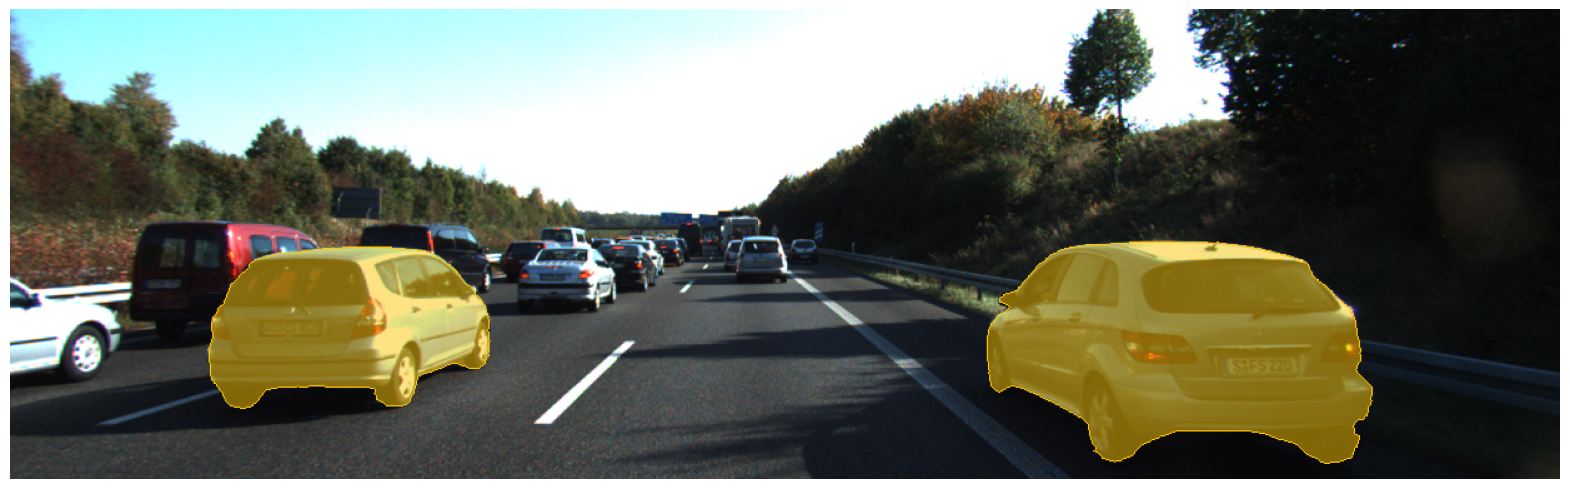

In [2]:
# define project id and photo context image id
photo_context_project_id = 43714
photo_context_image_id = 32382786

# download photo context image
photo_context_image_np = api.image.download_np(photo_context_image_id)
masked_photo_context_image_np = photo_context_image_np.copy()

# download photo context image annotation
project_meta_json = api.project.get_meta(photo_context_project_id)
project_meta = sly.ProjectMeta.from_json(project_meta_json)
ann_json = api.annotation.download(photo_context_image_id).annotation
ann = sly.Annotation.from_json(ann_json, project_meta)

# draw annotation on photo context image
ann.draw_pretty(masked_photo_context_image_np, thickness=1)

# create output directory
save_dir = "../tutorial_data/"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# save result
masked_photo_context_path = os.path.join(save_dir, "masked_photo_context.png")
masked_photo_context_image = Image.fromarray(masked_photo_context_image_np)
masked_photo_context_image.save(masked_photo_context_path)

# display result
plt.axis("off")
plt.imshow(masked_photo_context_image);

### Download input point cloud

Next step - download input point cloud to local storage.

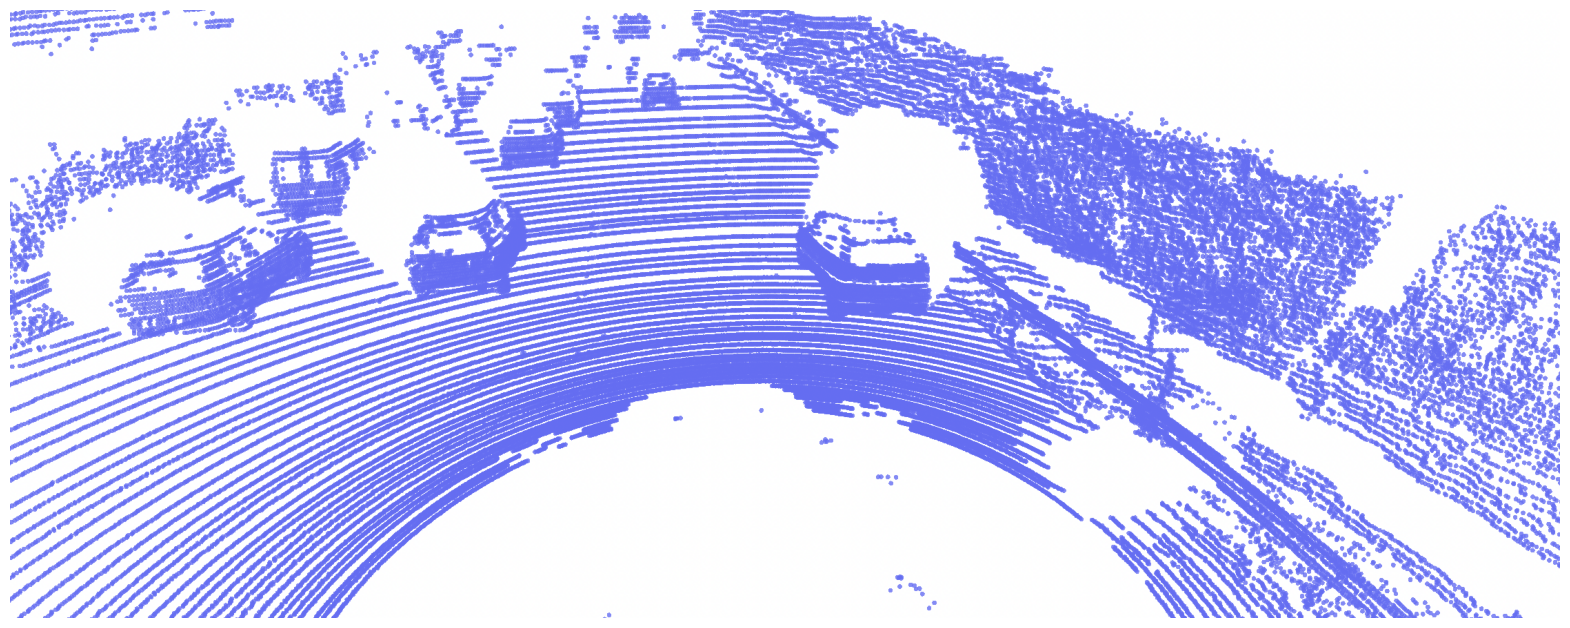

In [16]:
# define point cloud id and download it to local storage
pcd_id = 32384623
local_pcd_path = os.path.join(save_dir, "lidar_data.pcd")
api.pointcloud.download_path(pcd_id, local_pcd_path)

# display point cloud on interactive plot
# (github does not render interactive plotly charts, so static image will be displayed instead)
visualize_pcd(local_pcd_path)

### Get sensor calibration parameters

The KITTI [paper](https://www.cvlibs.net/publications/Geiger2013IJRR.pdf) describes the transformation from LiDAR to camera $i$ as follows, where each transformation matrix has been converted to it's homogeneous representation. The difference here is that we have changed the notation and added the transformation to the desired camera reference.

$$ \tilde{y} = P^{cam_i}_{rect_i} R^{rect_i}_{ref_i} T^{ref_i}_{ref0} T^{ref0}_{velo} \tilde{x},
  \qquad \text{where } \tilde{x} = [x, y, z, 1]^T $$

$$ \tilde{y} = \left( \tilde{u}, \tilde{v}, z, 1 \right) $$

For convenience we will denote the transformation from LiDAR to Camera $i$ like Isaac Berrios [proposed](https://github.com/itberrios/CV_tracking/blob/main/kitti_tracker/1_kitti_object_detection_lidar.ipynb) in his sensor fusion tutorial:

$$ T^{cam_i}_{velo} = P^{cam_i}_{rect_i} R^{rect_i}_{ref_i} T^{ref_i}_{ref0} T^{ref0}_{velo} $$

Where 
- $T^{ref}_{velo}$ - LiDAR to Camera Reference &rarr; transforms a 3D point relative to the LiDAR to a 3D point relative to the Camera
- $T^{ref_i}_{ref0}$ - Rigid Body Transformation from Camera 0 to Camera $i$
- $R^{rect_i}_{ref_i}$ - Camera $i$ to Rectified Camera $i$ reference 
- $P^{cam_i}_{rect_i}$ - Rectified Camera $i$ to 2D Camera $i$ $(u,v,z)$ coodinate space
- $T^{cam_i}_{velo}$ - 3D LiDAR space to 2D Camera $i$ $(u,v,z)$ coordinate space.

Where $(u,v,z)$ are the final camera coordinates after the rectification and projection transforms. In order to transform from homogeneous image coordinates $\tilde{y}$ to true $(u, v, z)$ image coordinates y, we will need to normalize by the depth and drop the 1:

$$ y = \left( \frac{\tilde{u}}{z}, \frac{\tilde{v}}{z}, z \right) $$

In [4]:
# define target camera number
camera_number = 2

# read calib_cam_to_cam.txt
calib_cam_to_cam_file = open("../tutorial_data/calib_cam_to_cam.txt")
calib_cam_to_cam_dict = {}
for line in calib_cam_to_cam_file.readlines():
    key, value = line.split(": ")
    calib_cam_to_cam_dict[key] = value.strip()
calib_cam_to_cam_file.close()

# read calib_velo_to_cam.txt
calib_velo_to_cam_file = open("../tutorial_data/calib_velo_to_cam.txt")
calib_velo_to_cam_dict = {}
for line in calib_velo_to_cam_file.readlines():
    key, value = line.split(": ")
    calib_velo_to_cam_dict[key] = value.strip()
calib_velo_to_cam_file.close()

In [5]:
# get projection matrices
P_rect = calib_cam_to_cam_dict[f"P_rect_0{camera_number}"]
P_rect = np.array([float(x) for x in P_rect.split(" ")]).reshape(
    (3, 4)
)
P_rect

array([[ 7.188560e+02,  0.000000e+00,  6.071928e+02,  4.538225e+01],
       [ 0.000000e+00,  7.188560e+02,  1.852157e+02, -1.130887e-01],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  3.779761e-03]])

In [6]:
# get rectified rotation matrices
R_rect = calib_cam_to_cam_dict[f"R_rect_0{camera_number}"]
R_rect = np.array([float(x) for x in R_rect.split(" ")]).reshape(
    (3, 3)
)
# add (0, 0, 0) translation and convert to homogeneous coordinates
R_rect = np.insert(R_rect, 3, values=[0, 0, 0], axis=0)
R_rect = np.insert(R_rect, 3, values=[0, 0, 0, 1], axis=1)
R_rect

array([[ 9.999191e-01,  1.228161e-02, -3.316013e-03,  0.000000e+00],
       [-1.228209e-02,  9.999246e-01, -1.245511e-04,  0.000000e+00],
       [ 3.314233e-03,  1.652686e-04,  9.999945e-01,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [7]:
# get rotation matrix from reference camera to target camera
R = calib_cam_to_cam_dict[f"R_0{camera_number}"]
R = np.array([float(x) for x in R.split(" ")]).reshape((3, 3))
# get translation vector from reference camera to target camera
t = calib_cam_to_cam_dict[f"T_0{camera_number}"]
t = np.array([float(x) for x in t.split(" ")]).reshape((3, 1))
# get reference camera to target camera rigid body transformation in homogeneous coordinates
T_ref_to_target = np.insert(np.hstack((R, t)), 3, values=[0, 0, 0, 1], axis=0)
T_ref_to_target

array([[ 9.999788e-01, -5.008404e-03, -4.151018e-03,  5.954406e-02],
       [ 4.990516e-03,  9.999783e-01, -4.308488e-03, -7.675338e-04],
       [ 4.172506e-03,  4.287682e-03,  9.999821e-01,  3.582565e-03],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [8]:
# get lidar to camera reference transformation
R_velo = np.array([float(x) for x in calib_velo_to_cam_dict["R"].split(" ")]).reshape((3, 3))
t_velo = np.array([float(x) for x in calib_velo_to_cam_dict["T"].split(" ")])[:, None]
T_velo_ref0 = np.vstack((np.hstack((R_velo, t_velo)), np.array([0, 0, 0, 1])))
T_velo_ref0

array([[ 7.967514e-03, -9.999679e-01, -8.462264e-04, -1.377769e-02],
       [-2.771053e-03,  8.241710e-04, -9.999958e-01, -5.542117e-02],
       [ 9.999644e-01,  7.969825e-03, -2.764397e-03, -2.918589e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

### Project LiDAR 3D points on 2D photo context image

Now when we got all necessary transformation matrices, we can obtain matrix to transform 3D LiDAR points to 2D camera coordinates.

In [9]:
# transform from velo (LiDAR) to target camera
T_velo_to_cam = P_rect @ R_rect @ T_ref_to_target @ T_velo_ref0
T_velo_to_cam

array([[ 6.07484390e+02, -7.18537361e+02, -1.01875822e+01,
        -9.55729189e+01],
       [ 1.80027463e+02,  5.89922104e+00, -7.20148711e+02,
        -9.34570810e+01],
       [ 9.99973895e-01,  4.85949260e-04, -7.20693419e-03,
        -2.84637351e-01]])

In [10]:
# get lidar points
pcd = o3d.io.read_point_cloud(local_pcd_path, format="pcd")
pcd_points = np.asarray(pcd.points)
xyzw = np.insert(pcd_points, 3, 1, axis=1).T
xyzw

array([[70.12200165, 69.74500275, 68.9509964 , ...,  3.76300001,
         3.7809999 ,  3.77699995],
       [37.46500015, 37.54600143, 37.39799881, ..., -1.42400002,
        -1.41700006, -1.40900004],
       [ 2.89700007,  2.88800001,  2.86199999, ..., -1.75999999,
        -1.76699996, -1.76400006],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [11]:
# get 3D points projections on photo context image
projections = T_velo_to_cam @ xyzw
projections[:2] /= projections[2, :]
projections

array([[222.71653185, 219.79103526, 216.86000628, ..., 925.86836546,
        922.80742564, 921.52290694],
       [152.7242648 , 152.67601167, 152.61939769, ..., 528.05500769,
        527.71001796, 527.50650563],
       [ 69.83286137,  69.45597654,  68.66210638, ...,   3.49025664,
          3.50830991,   3.50429233]])

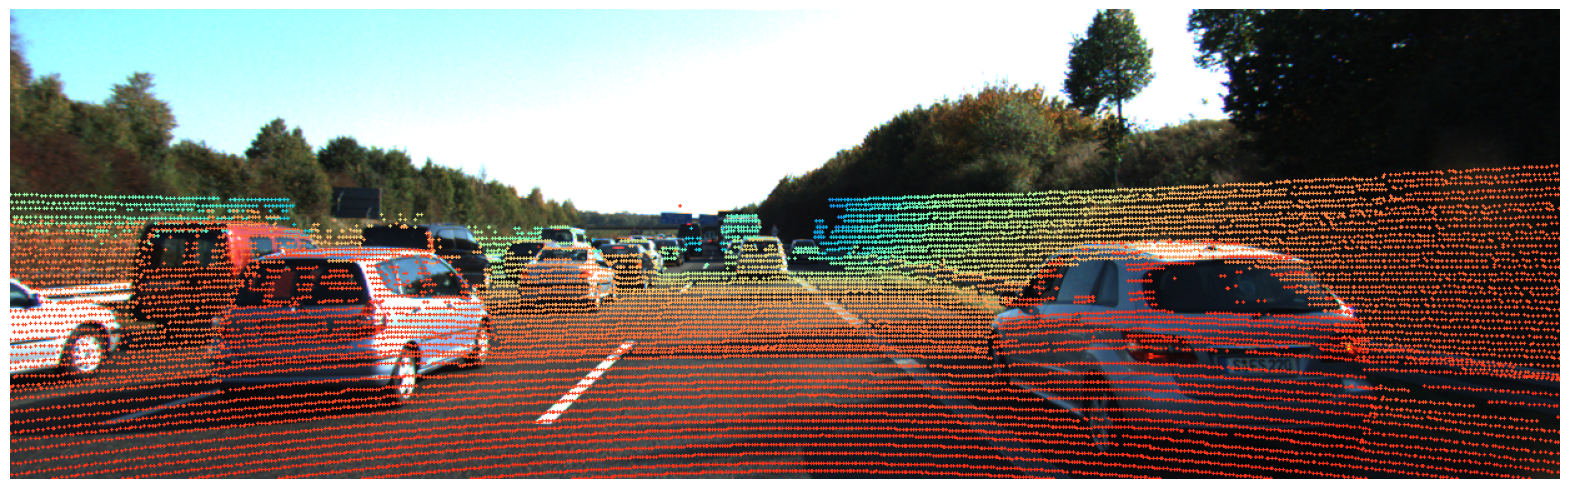

In [12]:
# draw point projections on image and display result
save_path = os.path.join(save_dir, "projections.png")
draw_projections_on_image(projections.copy(), photo_context_image_np.copy(), save_path)
plt.axis("off")
plt.imshow(Image.open(save_path));

### Get LiDAR point projections located inside masks on photo context image

Next step after we got LiDAR point projections - find projections which are located inside masks on photo context image (in our case we need to find find point projections which lie on two cars in front of ego vehicle).

In [13]:
# download photo context image annotation
project_meta_json = api.project.get_meta(photo_context_project_id)
project_meta = sly.ProjectMeta.from_json(project_meta_json)
ann_json = api.annotation.download(photo_context_image_id).annotation
ann = sly.Annotation.from_json(ann_json, project_meta)

# get binary masks
labels = ann.labels
bitmap = np.zeros(photo_context_image_np.shape, dtype=np.uint8)
for label in labels:
    geometry = label.geometry
    geometry.draw(bitmap=bitmap, color=[1, 1, 1])
bitmap = bitmap[:, :, :2]  # to 2d

# get indexes of projections which are located inside masks
u, v, z = projections
inside_masks = []
img_h, img_w, _ = photo_context_image_np.shape
for idx in range(len(pcd.points)):
    point = np.array([int(u[idx]), int(v[idx])])
    if (point[0] <= 0 or point[0] >= img_w) or (point[1] <= 0 or point[1] >= img_h):
        continue
    else:
        if np.all(bitmap[point[1], point[0]] == 1):
            inside_masks.append(idx)

print(f"{len(inside_masks)} point projections are located inside masks")

3949 point projections are located inside masks


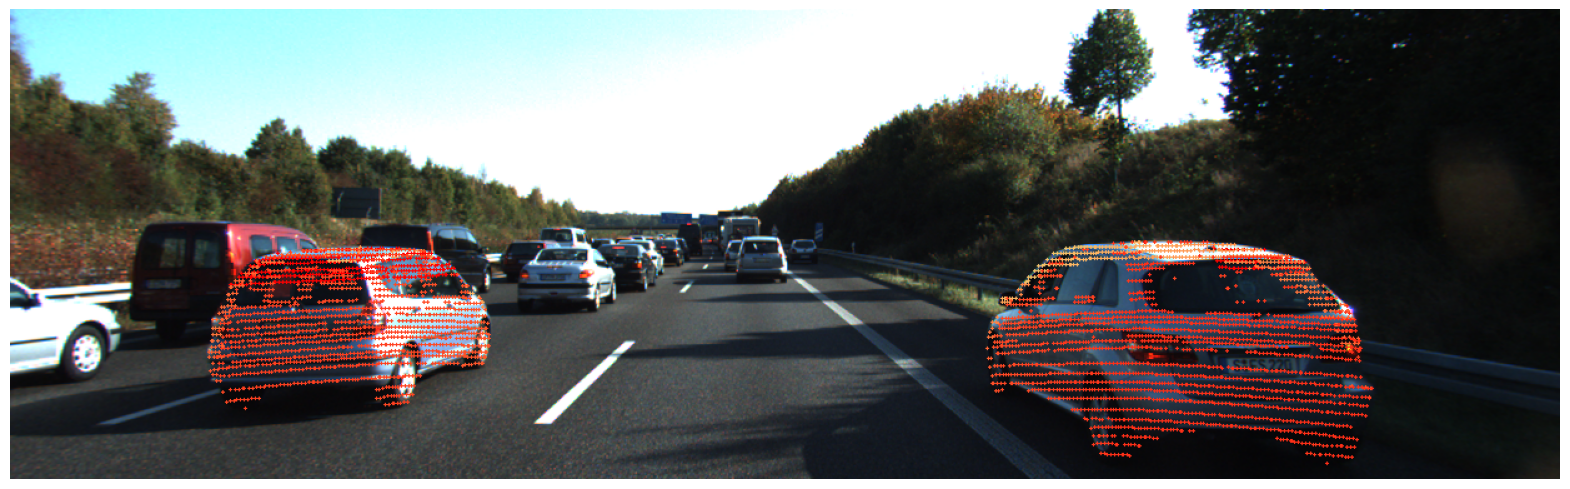

In [14]:
# display point projections located inside masks
masked_projections_save_path = os.path.join(save_dir, "masked_projections.png")
draw_projections_on_image(
    projections.copy(),
    photo_context_image_np.copy(),
    masked_projections_save_path,
    preprocess=False,
    indexes=inside_masks,
)
plt.axis("off")
plt.imshow(Image.open(masked_projections_save_path));

### Create 3D point cloud segmentation masks

Since 3D points and their projections have the same indexing, we can apply indexes of projections located inside masks on photo context image to original LiDAR points and get masked part of point cloud.

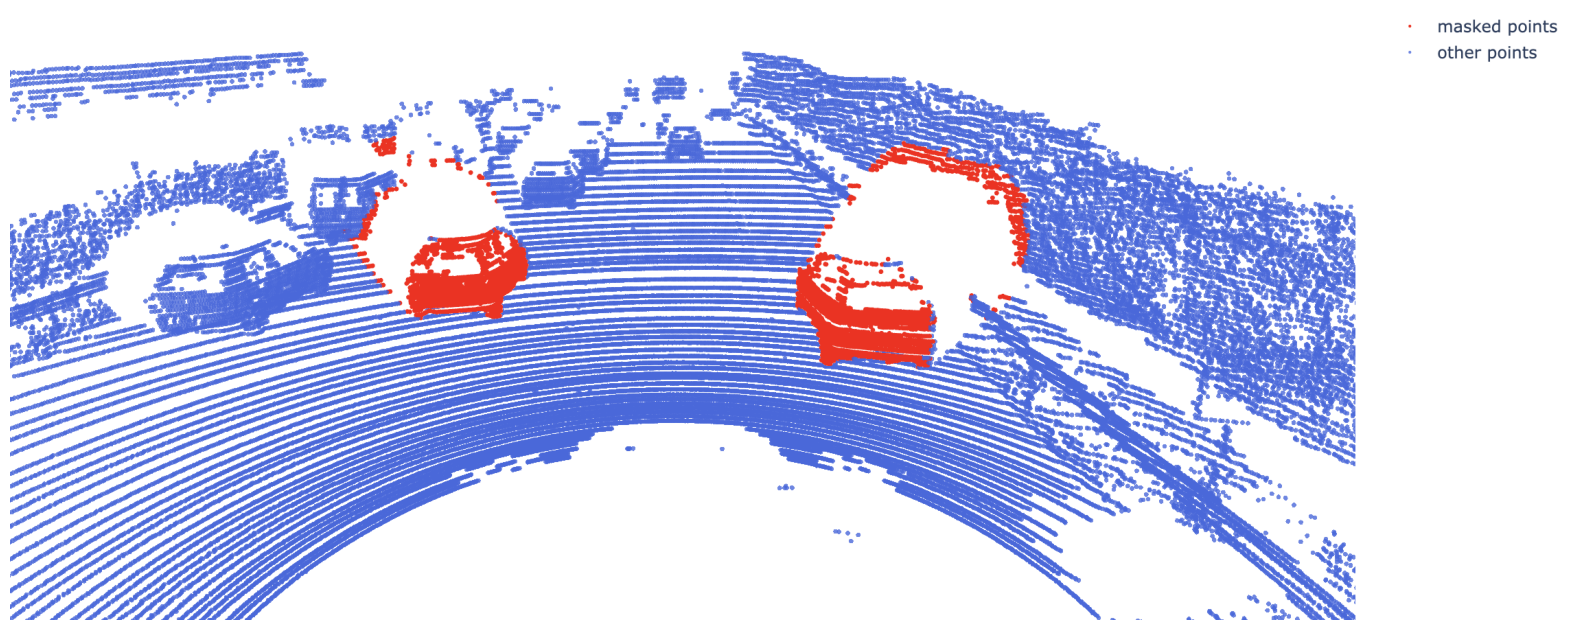

In [18]:
# transfer segmentation masks from 2D to 3D and display result (renders only in nbviewer, not on github)
# (github does not render interactive plotly charts, so static image will be displayed instead)
visualize_3d_masks(local_pcd_path, inside_masks)

As you can see, not only points of target objects (cars) were segmented - there are also points in front and behind target objects, whose projections are located on target objects on 2D image. Such scenario was quite predictable since in 3D space points can have similar x and y coordinates, but different z coordinates - their projections will be almost the same, but in 3D space these points can be located in completely different parts of point cloud.

In order to handle such corner case, we will have to apply some postprocessing to masked LiDAR points in order to filer points which do not belong to our target objects.

When it comes to postprocessing 2D to 3D segmentation transfer results, in most cases points which belong to target objects (in our case cars) will be in majority and other points (in our case points of surrounding environment, which we don't want to segment) will be in minority. Additionally, we can state that points of target objects and points of surrounding environment are most likely to be distant from each other. 

What can we do with this information? We can apply clustering algorithm to masked part of our point cloud and find N biggest clusters (where N equals number of target objects / segmentation masks, in our case - 2) - since "target" points and "noise" points are likely to be distant from each other and "target" points are likely to have higher density than other points, there is a high probability that points of target objects will belong to biggest clusters. Let's apply DBScan clustering algorithm and test this hypothesis:

In [19]:
# cluster masked part of point cloud
pcd = o3d.io.read_point_cloud(local_pcd_path, format="pcd")
masked_pcd = pcd.select_by_index(inside_masks)
cluster_labels = np.array(masked_pcd.cluster_dbscan(eps=1.5, min_points=100))
clusters, counts = np.unique(cluster_labels, return_counts=True)
# we recommend to set number of clusters equal to number of segmentation masks on photo context image
n_biggest_clusters = len(ann.labels)
biggest_clusters = clusters[np.argsort(counts)][-n_biggest_clusters:]
biggest_cluster_indexes = []
for idx, label in enumerate(cluster_labels):
    if label in biggest_clusters:
        biggest_cluster_indexes.append(idx)
inside_masks_processed = [inside_masks[idx] for idx in biggest_cluster_indexes]
print(f"{len(inside_masks) - len(inside_masks_processed)} points were filtered using DBScan clustering")

973 points were filtered using DBScan clustering


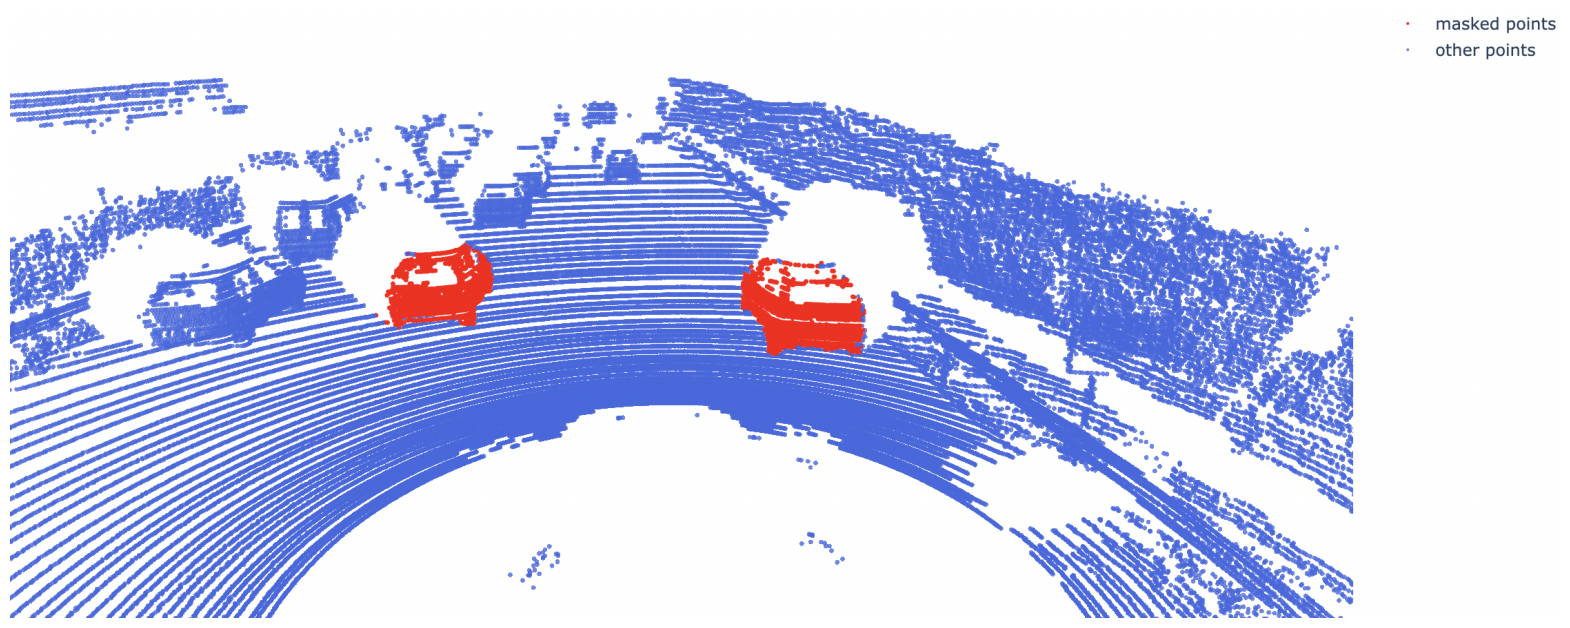

In [21]:
# display point filtering results
# (github does not render interactive plotly charts, so static image will be displayed instead)
visualize_3d_masks(local_pcd_path, inside_masks_processed)

As you can see, for our case, DBScan perfectly filtered points which do not belong to target objects.

### Upload created 3D segmentation mask to Supervisely platform

Now, when we have indexes of target object's points in 3D space, we can create 3D point cloud segmentattion annotation and upload it to Supervisely platform. We will create new point cloud project and upload to it input point cloud, masked photo context image and 3D segmentation mask.

In [18]:
# create output project
pcd_project = api.project.create(
    657,
    "Segmented point cloud",
    change_name_if_conflict=True,
    type=ProjectType.POINT_CLOUDS,
)
pcd_dataset = api.dataset.create(pcd_project.id, "ds_0", change_name_if_conflict=True)

# upload point cloud to output project
pcd_info = api.pointcloud.upload_path(pcd_dataset.id, name="scene.pcd", path=local_pcd_path)

# upload related image to output project
related_image_hash = api.pointcloud.upload_related_image(masked_photo_context_path)

# create dict with camera info
extrinsic_matrix = T_velo_ref0[:3, :4]
extrinsic_matrix = extrinsic_matrix.flatten().tolist()
intrinsic_matrix = calib_cam_to_cam_dict["P_rect_00"]
intrinsic_matrix = np.array(intrinsic_matrix.split(" "), dtype=np.float32).reshape(3, 4)
intrinsic_matrix = intrinsic_matrix[:3, :3].flatten().tolist()
cam_info = {
    "deviceId": "cam_0",
    "sensorsData": {
        "extrinsicMatrix": extrinsic_matrix,
        "intrinsicMatrix": intrinsic_matrix,
    },
}

# create dict with image info
related_image_info = {
    "entityId": pcd_info.id,
    "name": "img_0.png",
    "hash": related_image_hash,
    "meta": cam_info,
}

# upload related image info
api.pointcloud.add_related_images([related_image_info])

{'success': True}

In [19]:
# upload point cloud segmentation mask to the platform
pcd_project_meta = sly.ProjectMeta.from_json(api.project.get_meta(pcd_project.id))

if not pcd_project_meta.get_obj_class("mask"):
    pcd_project_meta = pcd_project_meta.add_obj_class(sly.ObjClass("mask", Pointcloud))
    api.project.update_meta(pcd_project.id, pcd_project_meta.to_json())

ann_info = api.pointcloud.annotation.download(pcd_id)
pcd_objects = []
pcd_figures = []
geometry = Pointcloud(inside_masks_processed)
pcd_object = sly.PointcloudObject(pcd_project_meta.get_obj_class("mask"))
pcd_figure = sly.PointcloudFigure(pcd_object, geometry)
pcd_objects.append(pcd_object)
pcd_figures.append(pcd_figure)
pcd_objects = PointcloudObjectCollection(pcd_objects)
result_ann = sly.PointcloudAnnotation(
    pcd_objects, pcd_figures, PointcloudTagCollection([])
)
api.pointcloud.annotation.append(pcd_info.id, result_ann)

2D and 3D segmentation masks comparison:

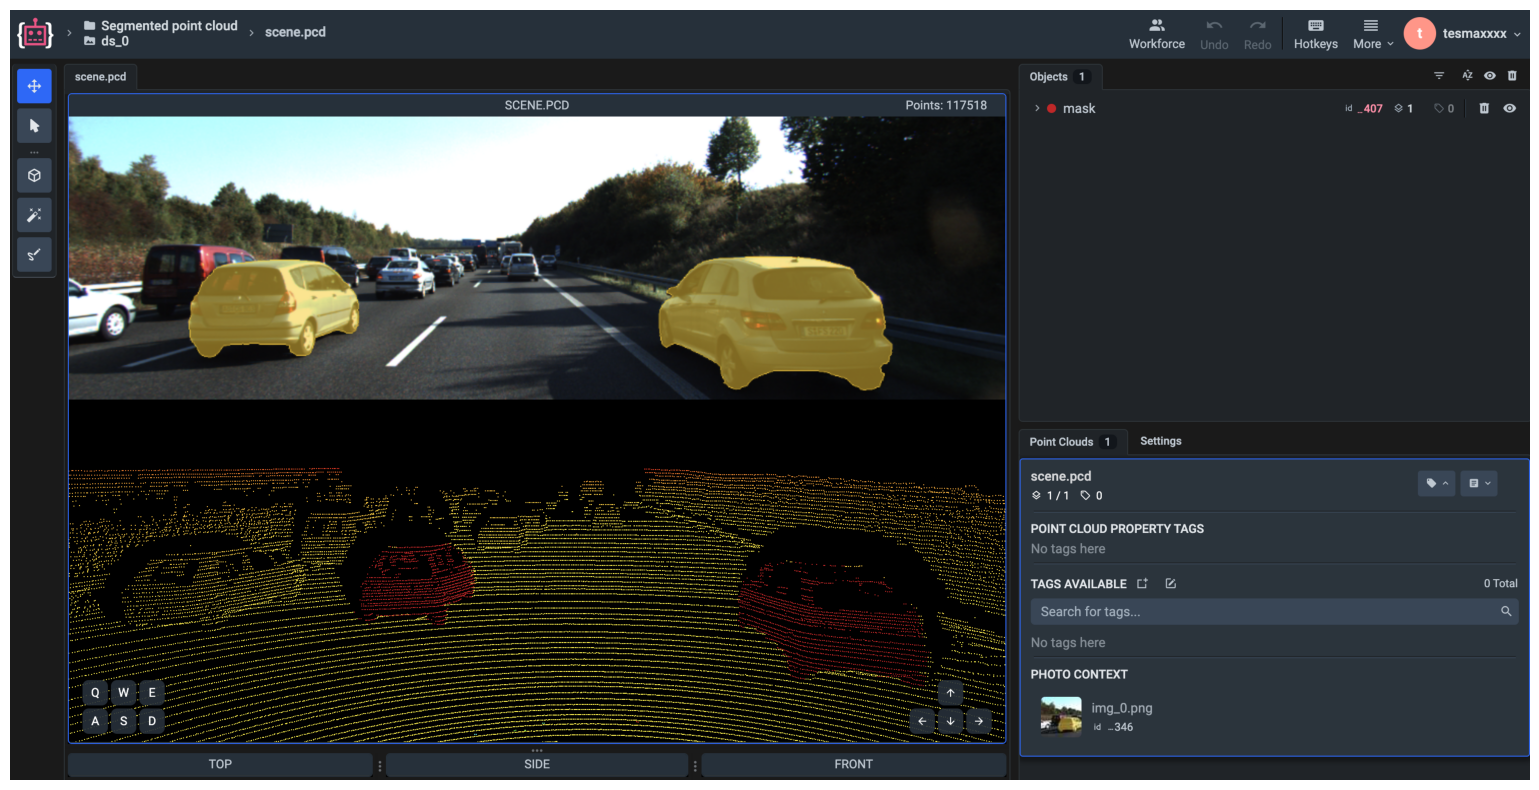

In [22]:
# screenshot from the platform
plt.axis("off")
plt.imshow(Image.open("../tutorial_data/result.png"));

### Conclusion

In this tutorial, we used 2D mask guidance, sensor calibration matrices and DBScan clustering algorithm in order to transfer 2D segmentation mask to 3D space. This approach can be useful when there is a need in fast 3D point clouds labeling for instance segmentation tasks. For example, we can apply YOLO11 model for instance segmentation to each photo context image in KITTI dataset and transfer 2D masks to 3D space using sensor calibration data - it will allow to create a huge labeled dataset for 3D instance segmentation without having to manually draw segmentation masks in every point cloud. Alternative ways of 3D point clouds labeling will be covered in future tutorials.

### Acknowledgement

This tutorial is based on [great work](https://github.com/itberrios/CV_tracking/tree/main) by Isaac Berrios.